# Exemplo de Rede Neural Bayesiana

                         Referências:
                         https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd
                         Exemplo fornecido em sala de aula:
                         https://colab.research.google.com/drive/1HCf4dOv3n2cqGWR0fnxyMz8BZByaw4Sd?usp=sharing#scrollTo=iu2okyYmghEc

O grande diferencial das Redes Neurais Bayesianas é que elas são capazes de identificar situações em que os dados fogem muito dos padrões de treinamento e em que a rede neural não deveria ser considerada como válida. Por exemplo, em uma rede treinada para reconhecer números não é apropriada para detectar letras, caracteres especiais, desenhos e fotos. Neste caso é útil que o modelo nos diga "não sei" nestes casos. 




#### Instalação dos pacotes necessários.

In [20]:
#          Sugiro executar o comando abaixo e reiniciar o jupyterlab
#          Ao retornar, acione o menu kernel, Change Kernel e selecione o venv_pytorch
#
#!python3 -m ipykernel install --user --name venv_pytorch

#!pip install scipy
#
#          O comando de instalação apropriado para o pytorch pode ser encontrado em http://pytorch.org
#
#!pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install pyro-ppl==1.4.0

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset

In [2]:
if torch.cuda.device_count() != 0:
    print( f'torch.current_device={torch.cuda.current_device()}' )
    print( f'torch.current_device={torch.cuda.get_device_name(0)}' )
    gpu = torch.device("cuda")
else:
    print( f'No GPU detected' )   


torch.current_device=0
torch.current_device=GeForce 940MX


## Carrega e padroniza os dados 

In [4]:

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            'mnist-data/', 
            train=True, 
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
            ])
        ),
        batch_size=128,
        shuffle=True
)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            'mnist-data/', 
            train=False, 
            transform=transforms.Compose([
                transforms.ToTensor(),
            ] )
        ),
        batch_size=128, 
        shuffle=True
)

In [22]:
classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(
            'f-mnist-data/', 
            train=True, 
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
            ])
        ),
        batch_size=128,
        shuffle=True
)

test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(
            'f-mnist-data/', 
            train=False, 
            transform=transforms.Compose([
                transforms.ToTensor(),
            ] )
        ),
        batch_size=128, 
        shuffle=True
)

In [10]:
# define a arquitetura base da rede neural. 
# neste caso 

class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output
    
net = NN(28*28, 1024, 10)

#net.to(gpu)

In [23]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [24]:
log_softmax = nn.LogSoftmax(dim=1)

def model(x_data, y_data):
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)
    
    
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)

    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)

    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)

    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()




In [25]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [26]:
num_iterations = 5
loss = 0


for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  134.23291105087597
Epoch  1  Loss  97.96339643588067
Epoch  2  Loss  95.26399998510679
Epoch  3  Loss  96.50825028004647
Epoch  4  Loss  97.21262574659983


In [27]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += (predicted == labels.numpy()).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 73 %


In [28]:
def imshow(img):
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [29]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [101]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("-------------------------------------------------------------")
            fig, axs = plt.subplots(1, 11, sharey=False,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob > 0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j+1].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j+1].set_title(str(classes[j])+" ("+str(round(prob,2))+")") 
                
                if( j > 0 ):
                    axs[j+1].sharey(axs[1])
                    #axs[j+1].sharex(axs[1])
                    axs[j+1].set_ylim([0.0,1.0])
                    #axs[j+1].set_xlim([-520,20])
                    axs[j+1].axes.get_yaxis().set_visible(False)
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            axs[0].imshow(images[i].squeeze())
            axs[0].set_axis_off()
    
        if(plot):
            plt.tight_layout()
            plt.show()
            
        predicted = np.argmax(all_digits_prob)
    
        if(plot):
            print("Real:", classes[labels[i].item()], '===> Predicted: ', end='')            
    
        
        if(highted_something):
            predicted_for_images += 1
            if(labels[i].item() == predicted):
                if(plot):
                    print("Correct")
                correct_predictions += 1.0
            else:
                if(plot):
                    print(f"Incorrect ({classes[predicted]})")
        else:
            if(plot):
                print("Undecided.")
        
        
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        if predicted_for_images > 0:
            print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

In [105]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total - total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  10000
Skipped:  2798
Accuracy when made predictions: 87 %


-------------------------------------------------------------


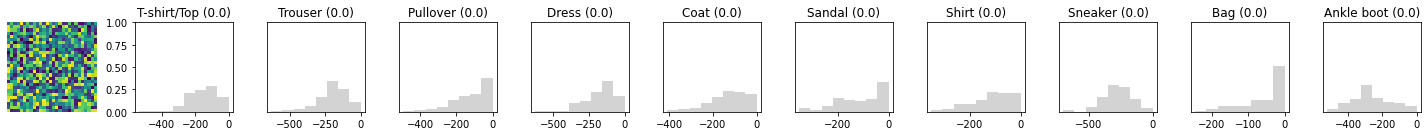

Real: Bag ===> Predicted: Undecided.
Summary
Total images:  1
Predicted for:  0


(1, 0, 0)

In [102]:
noisy_images, fake_labels = torch.rand(images[:1].shape), torch.randint(0,  10, labels[:1].shape)
test_batch(noisy_images, fake_labels)

In [106]:
# preparing for evaluation

dataiter = iter(test_loader)
images, labels = dataiter.next()

-------------------------------------------------------------


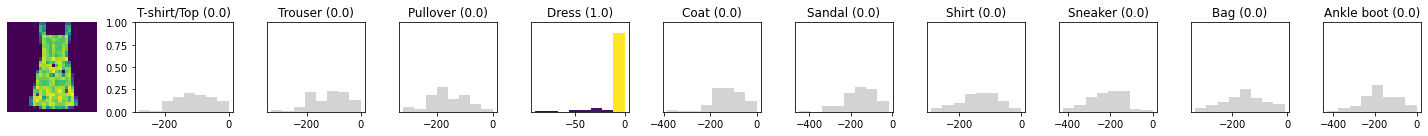

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


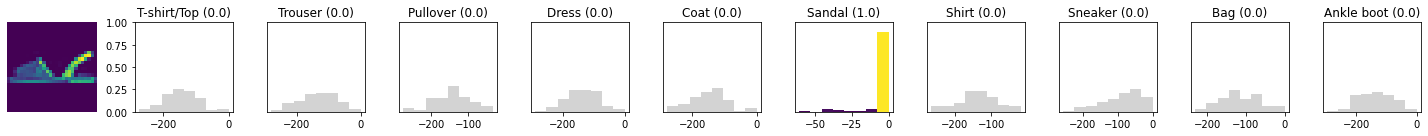

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


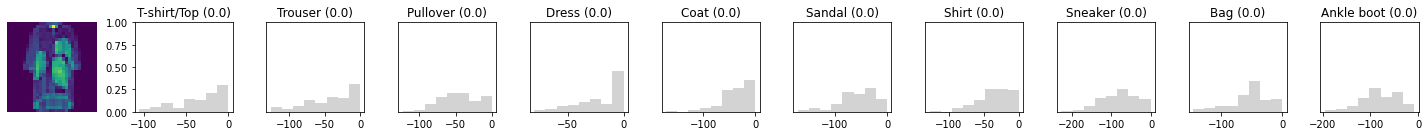

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


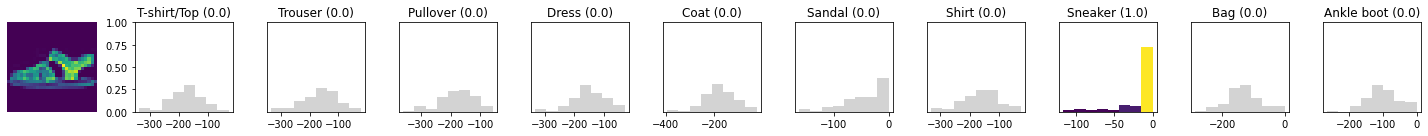

Real: Sandal ===> Predicted: Incorrect (Sneaker)
-------------------------------------------------------------


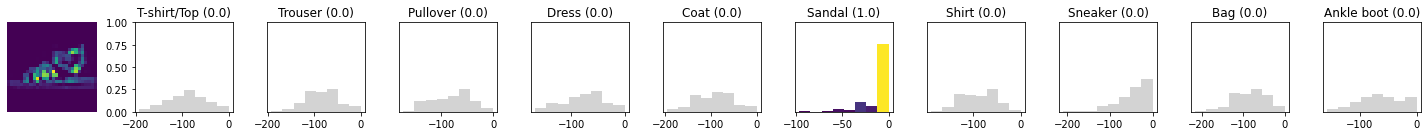

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


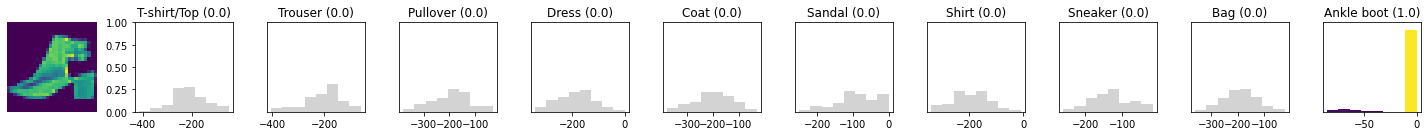

Real: Sandal ===> Predicted: Incorrect (Ankle boot)
-------------------------------------------------------------


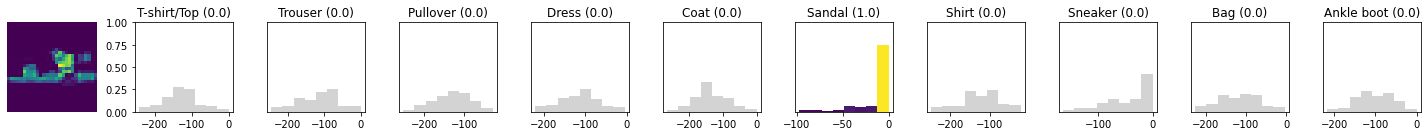

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


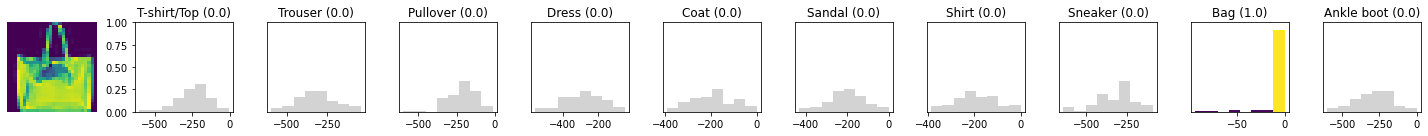

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


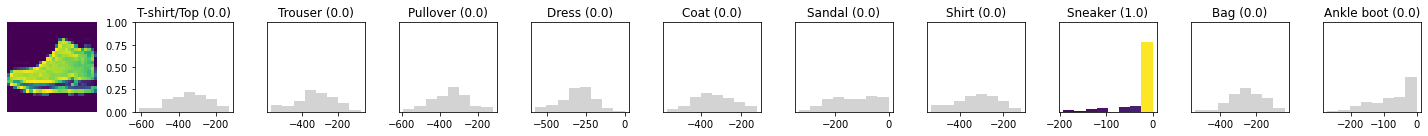

Real: Ankle boot ===> Predicted: Incorrect (Sneaker)
-------------------------------------------------------------


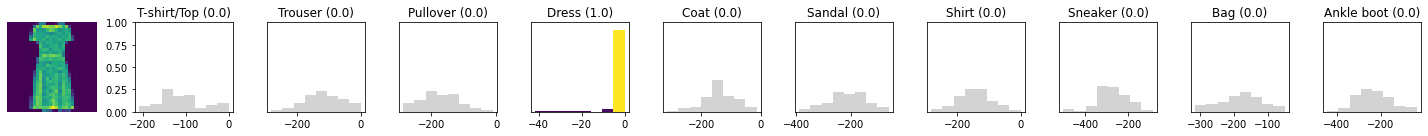

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


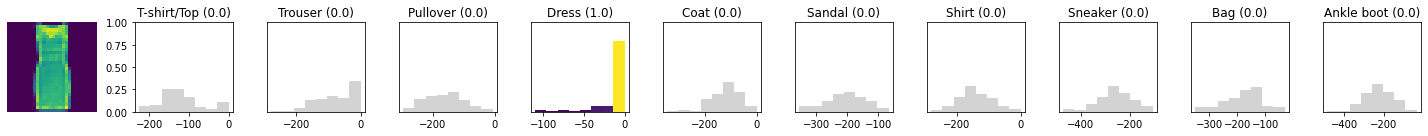

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


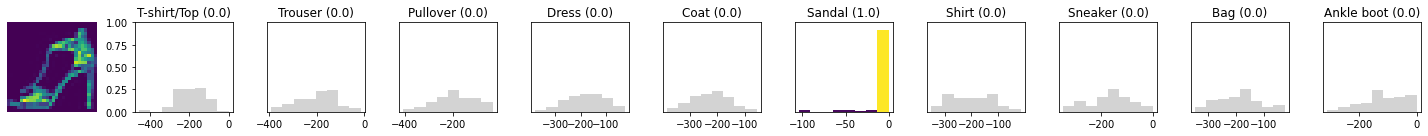

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


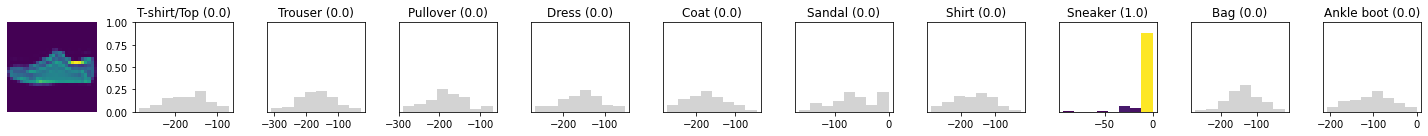

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


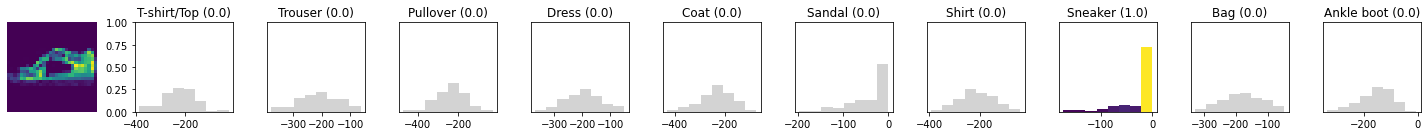

Real: Sandal ===> Predicted: Incorrect (Sneaker)
-------------------------------------------------------------


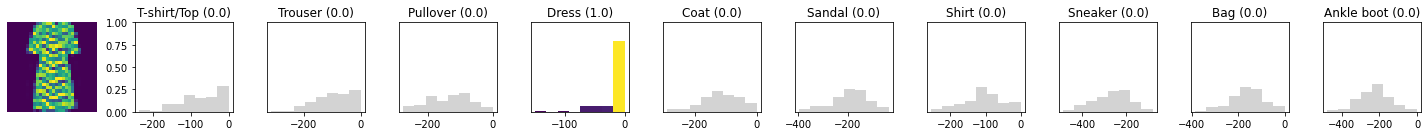

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


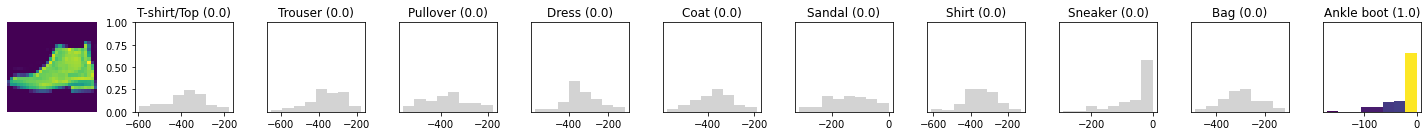

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


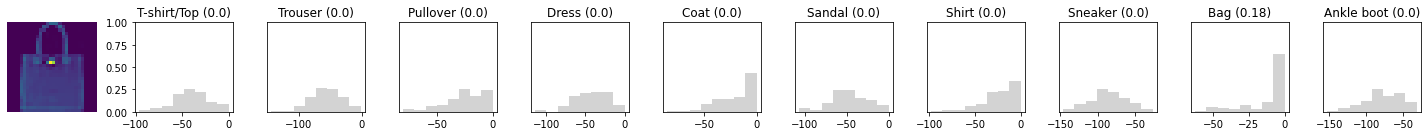

Real: Bag ===> Predicted: Undecided.
-------------------------------------------------------------


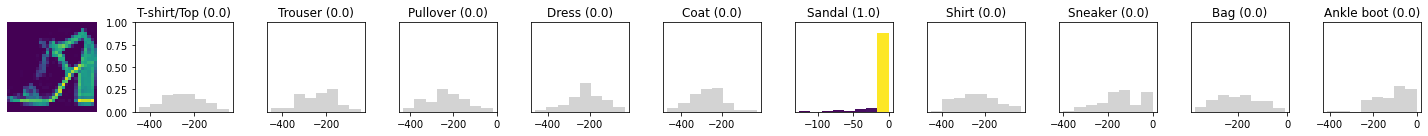

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


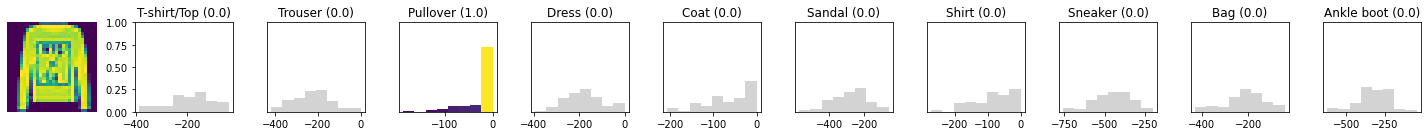

Real: Pullover ===> Predicted: Correct
-------------------------------------------------------------


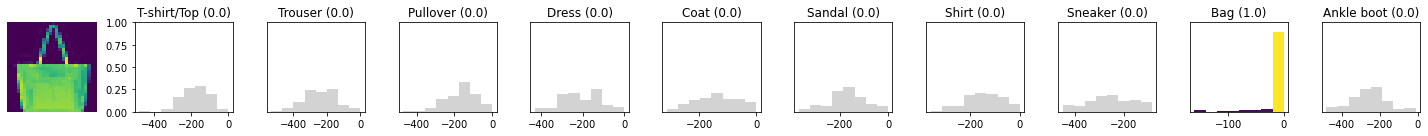

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


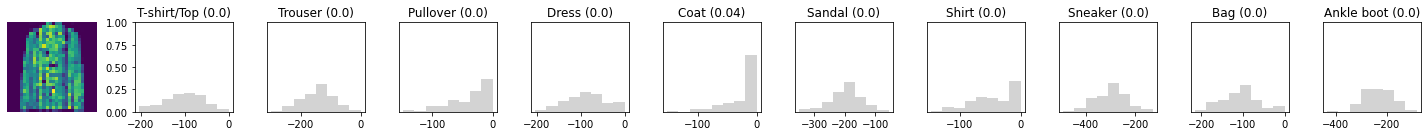

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


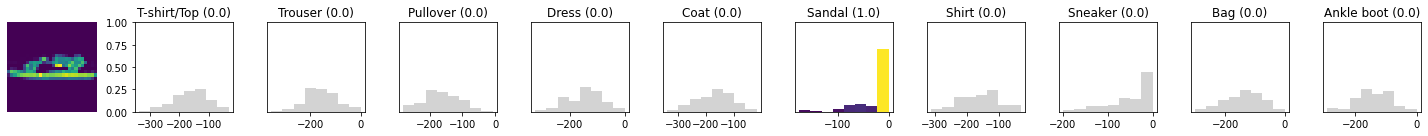

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


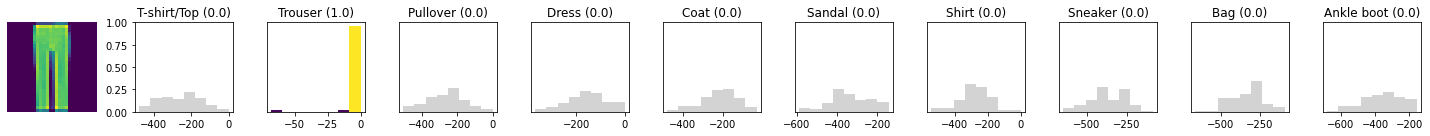

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


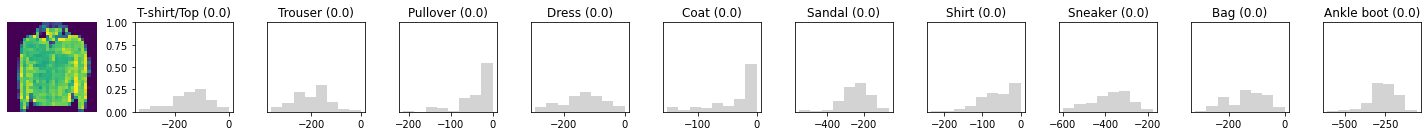

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


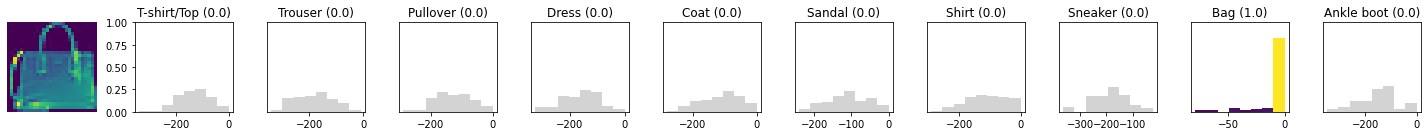

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


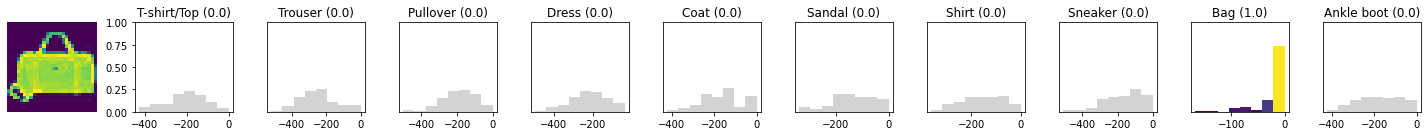

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


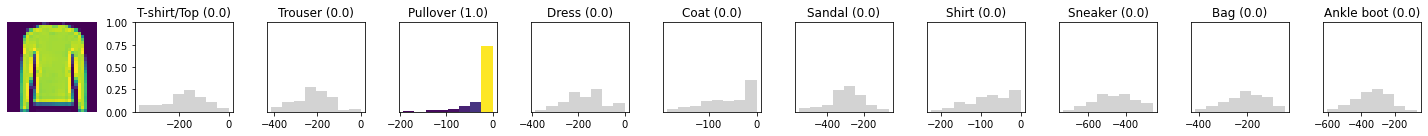

Real: Pullover ===> Predicted: Correct
-------------------------------------------------------------


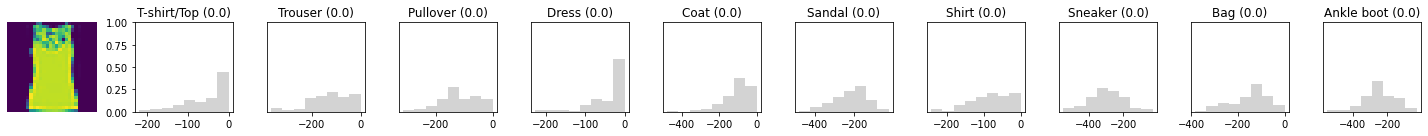

Real: T-shirt/Top ===> Predicted: Undecided.
-------------------------------------------------------------


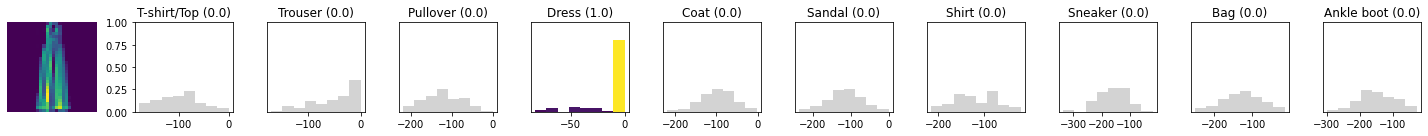

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


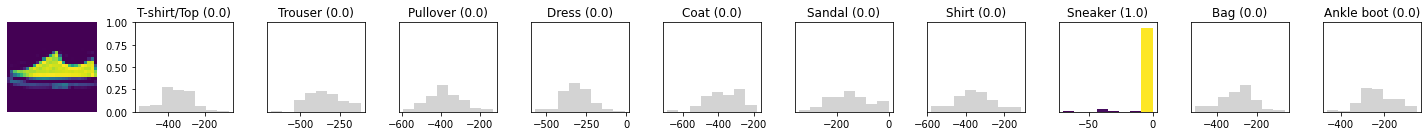

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


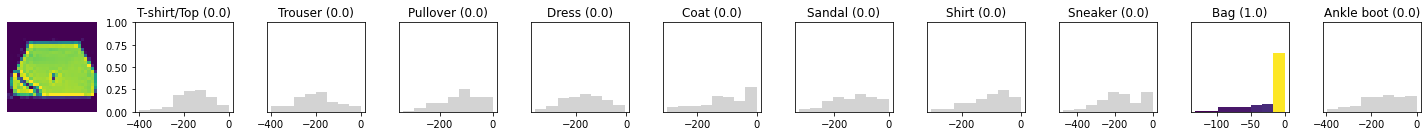

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


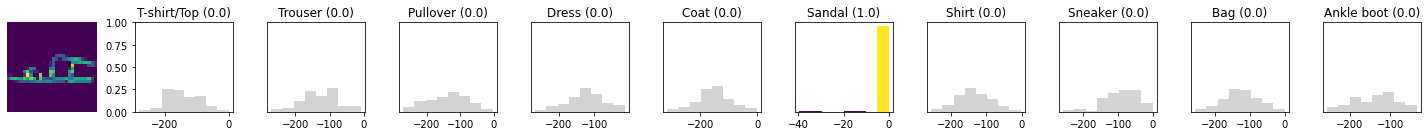

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


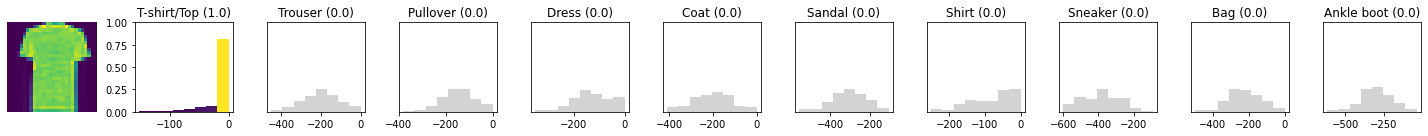

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


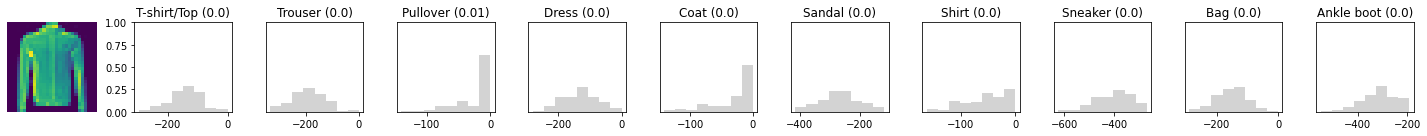

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


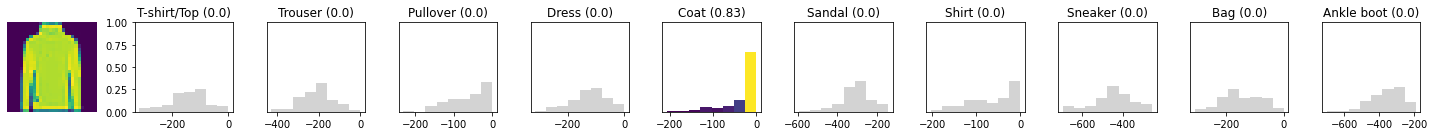

Real: Pullover ===> Predicted: Incorrect (Coat)
-------------------------------------------------------------


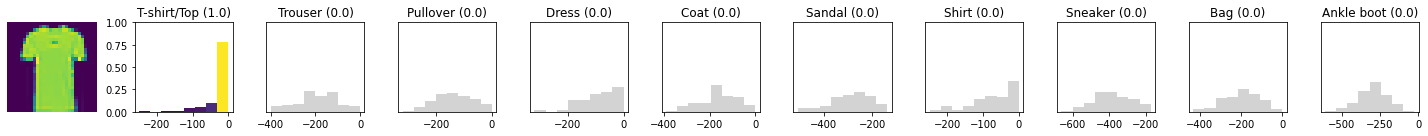

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


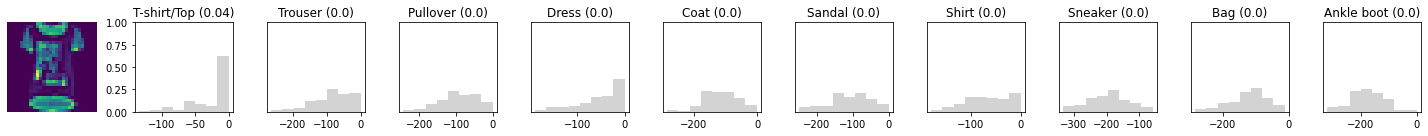

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


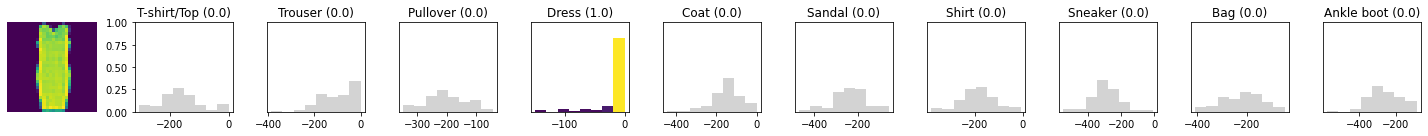

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


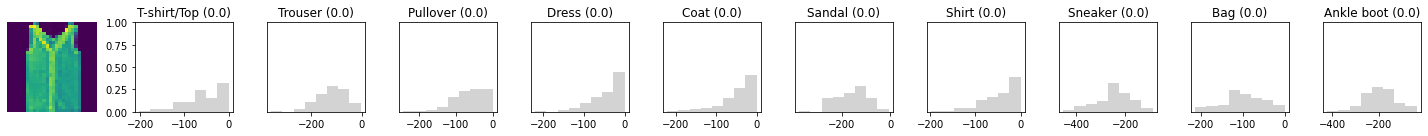

Real: T-shirt/Top ===> Predicted: Undecided.
-------------------------------------------------------------


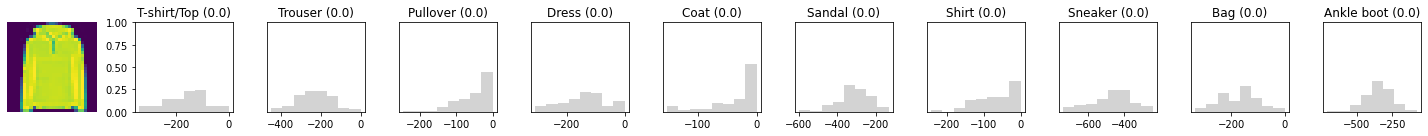

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


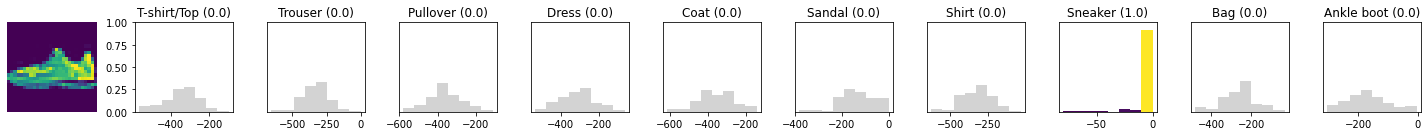

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


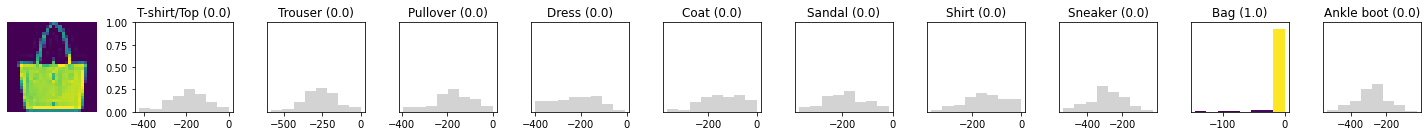

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


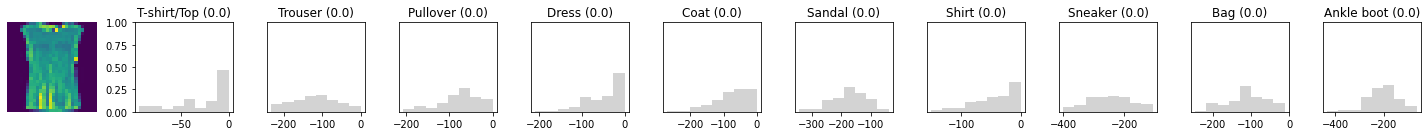

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


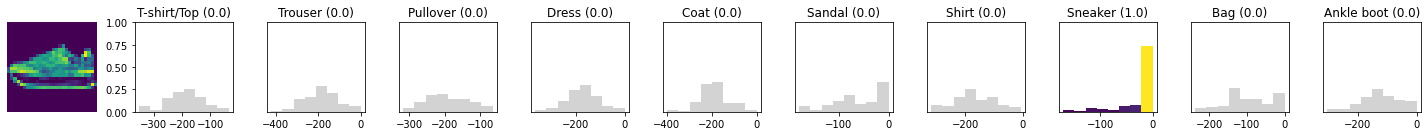

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


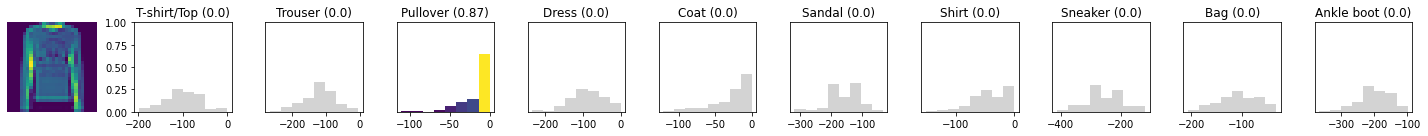

Real: Pullover ===> Predicted: Correct
-------------------------------------------------------------


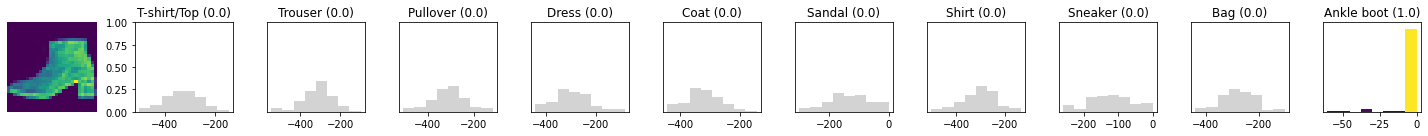

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


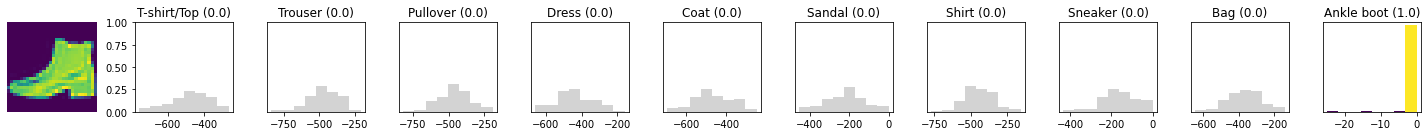

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


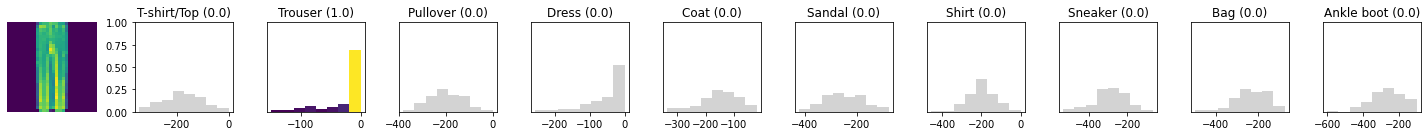

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


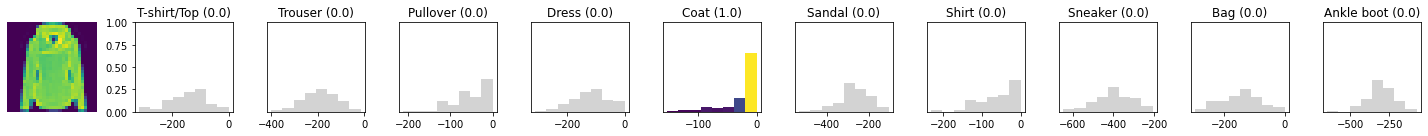

Real: Coat ===> Predicted: Correct
-------------------------------------------------------------


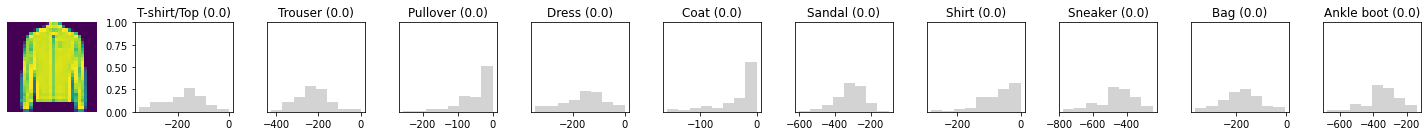

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


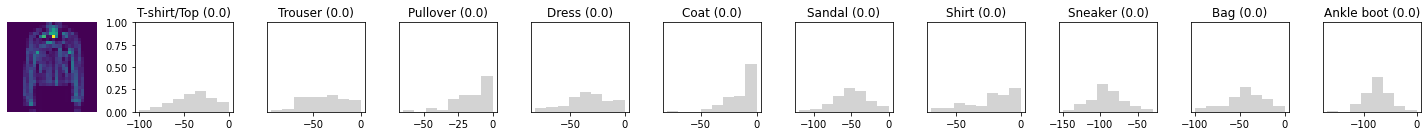

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


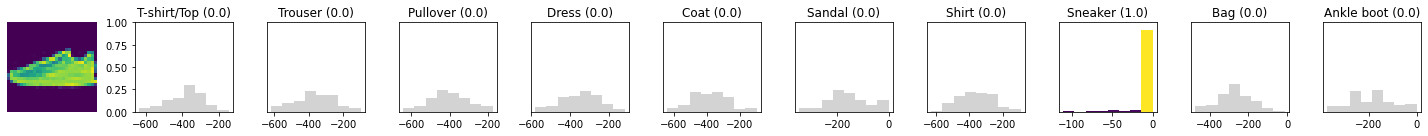

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


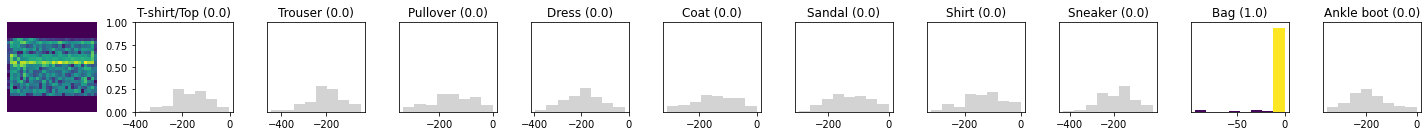

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


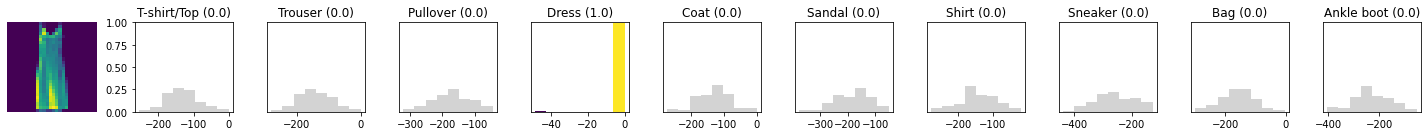

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


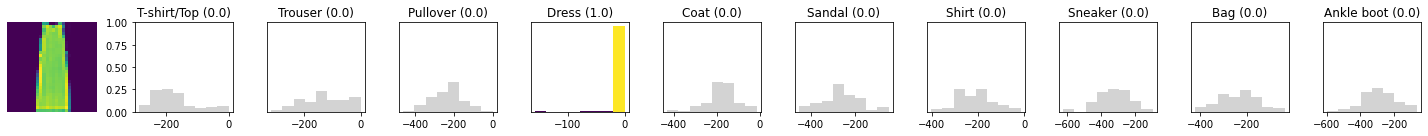

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


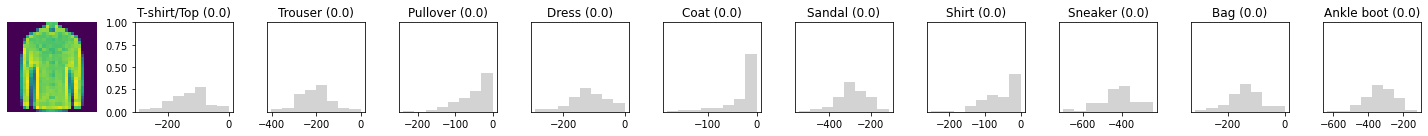

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


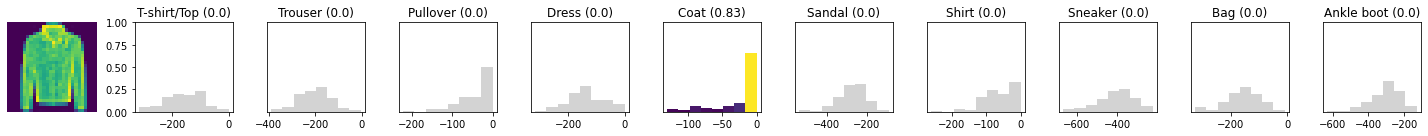

Real: Coat ===> Predicted: Correct
-------------------------------------------------------------


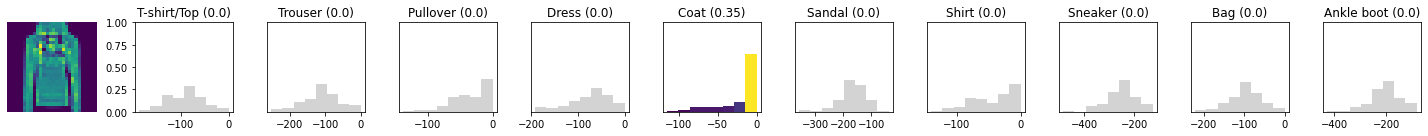

Real: Pullover ===> Predicted: Incorrect (Coat)
-------------------------------------------------------------


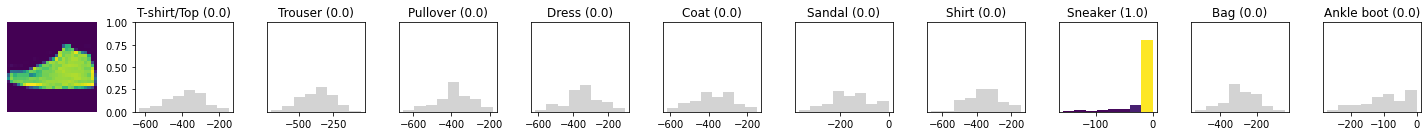

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


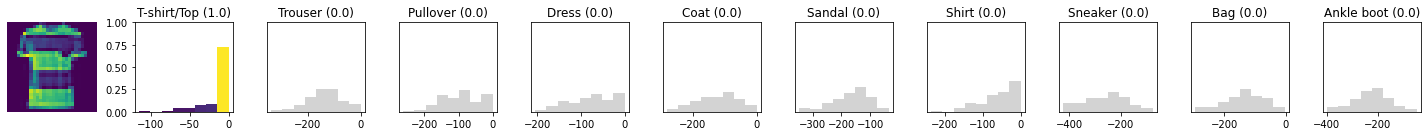

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


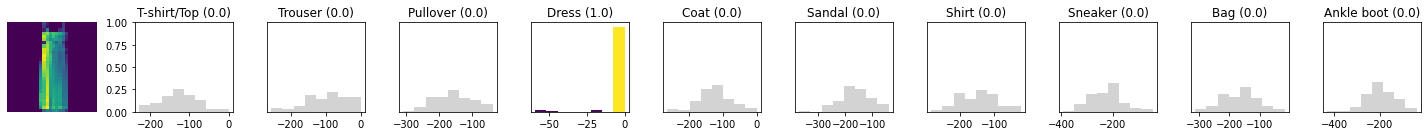

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


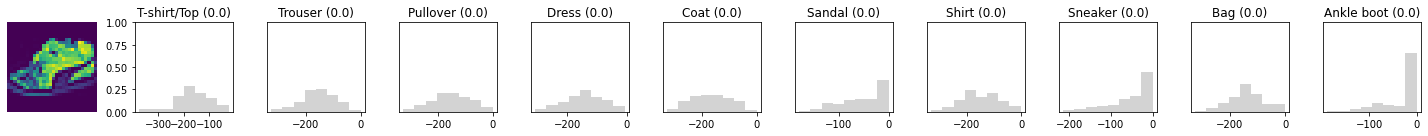

Real: Sneaker ===> Predicted: Undecided.
-------------------------------------------------------------


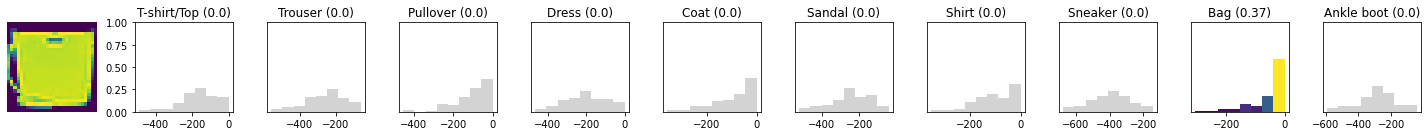

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


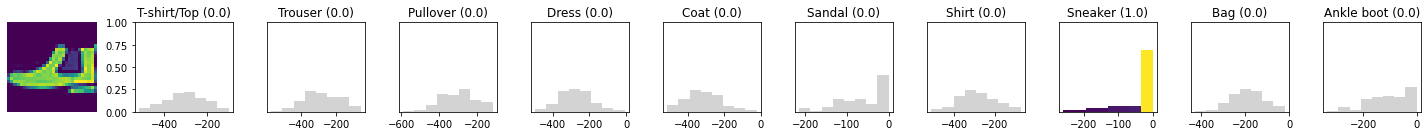

Real: Ankle boot ===> Predicted: Incorrect (Sneaker)
-------------------------------------------------------------


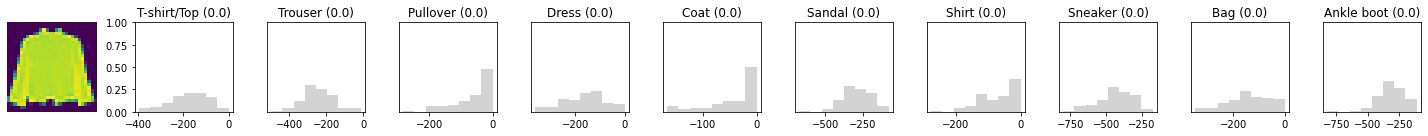

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


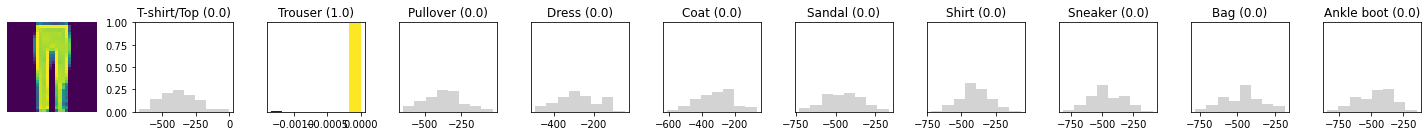

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


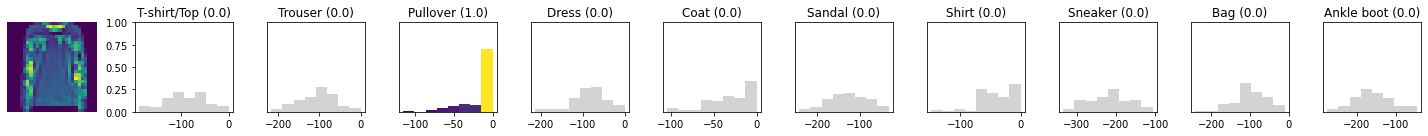

Real: Pullover ===> Predicted: Correct
-------------------------------------------------------------


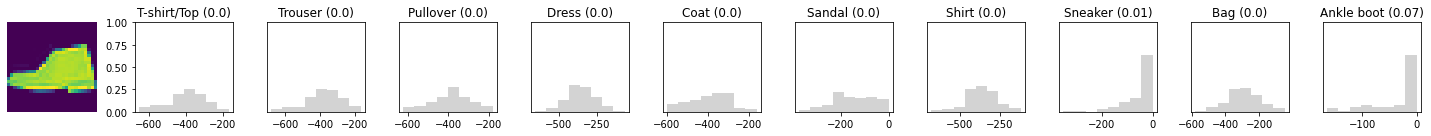

Real: Ankle boot ===> Predicted: Undecided.
-------------------------------------------------------------


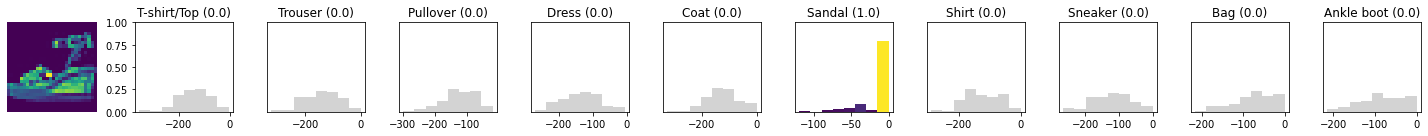

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


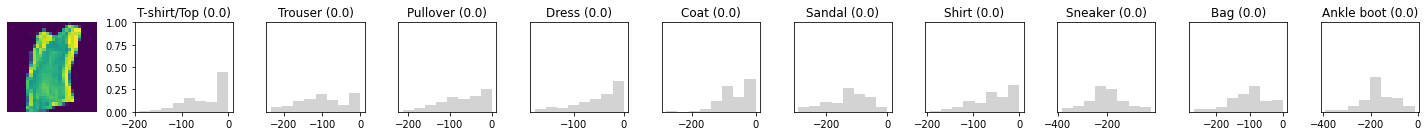

Real: T-shirt/Top ===> Predicted: Undecided.
-------------------------------------------------------------


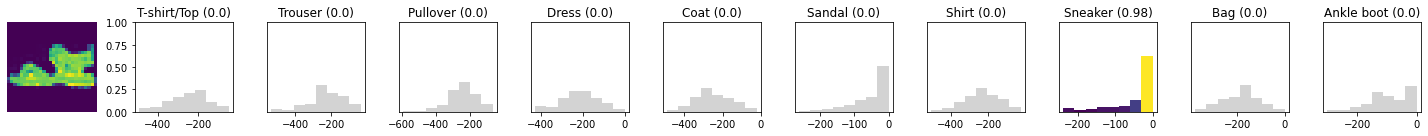

Real: Sandal ===> Predicted: Incorrect (Sneaker)
-------------------------------------------------------------


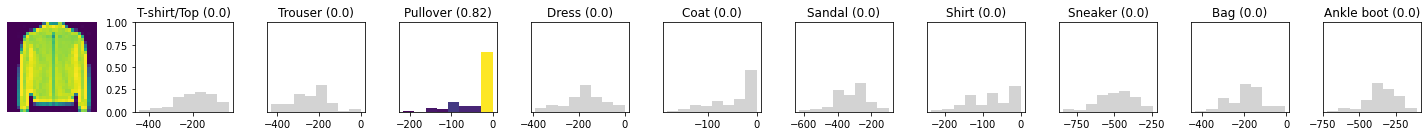

Real: Coat ===> Predicted: Incorrect (Pullover)
-------------------------------------------------------------


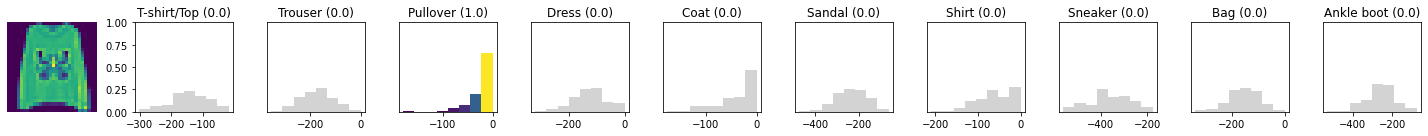

Real: Pullover ===> Predicted: Correct
-------------------------------------------------------------


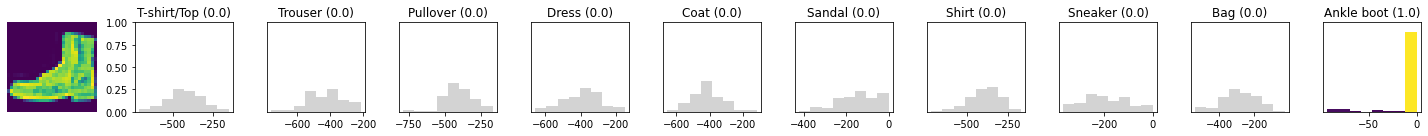

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


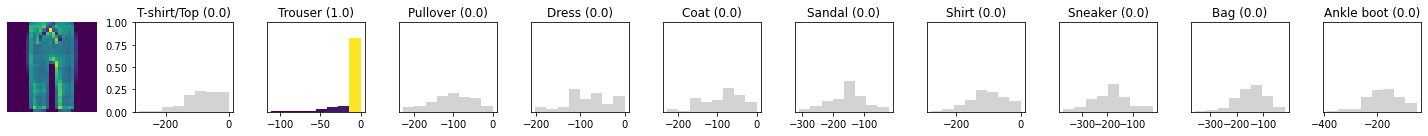

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


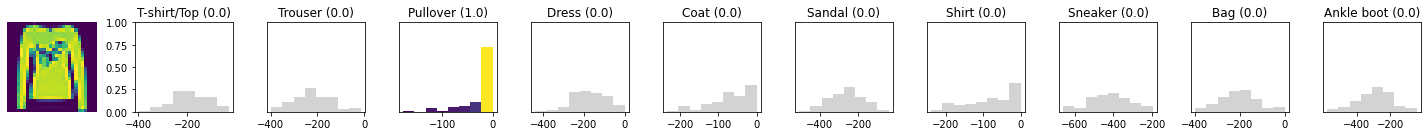

Real: Pullover ===> Predicted: Correct
-------------------------------------------------------------


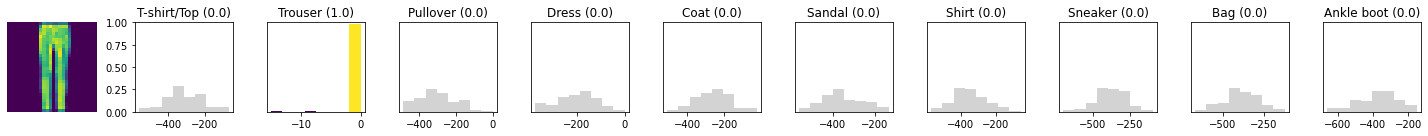

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


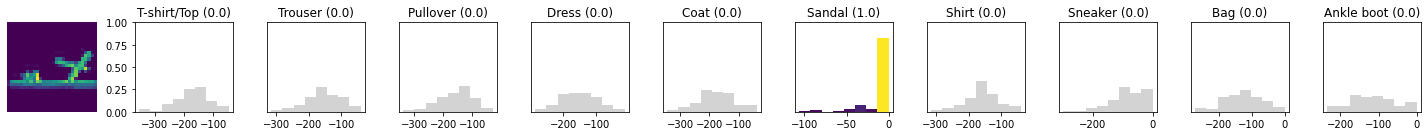

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


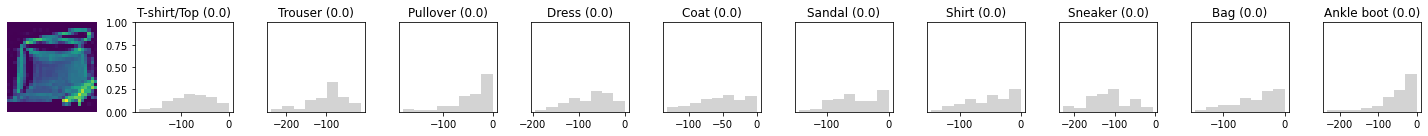

Real: Bag ===> Predicted: Undecided.
-------------------------------------------------------------


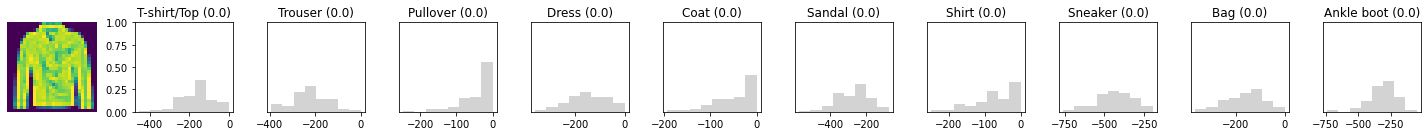

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


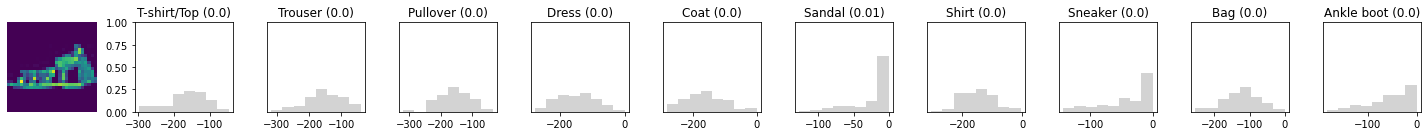

Real: Sandal ===> Predicted: Undecided.
-------------------------------------------------------------


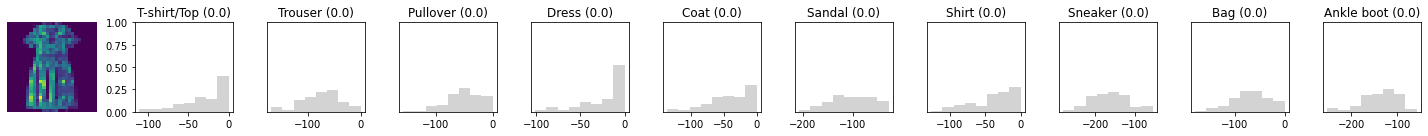

Real: Dress ===> Predicted: Undecided.
-------------------------------------------------------------


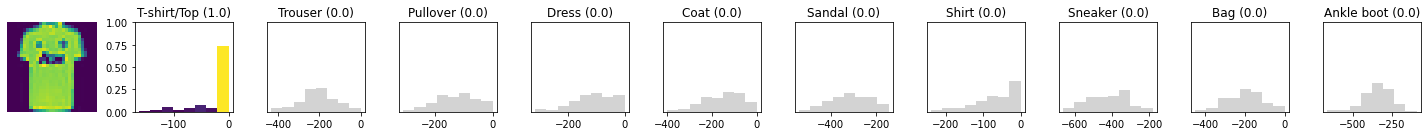

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


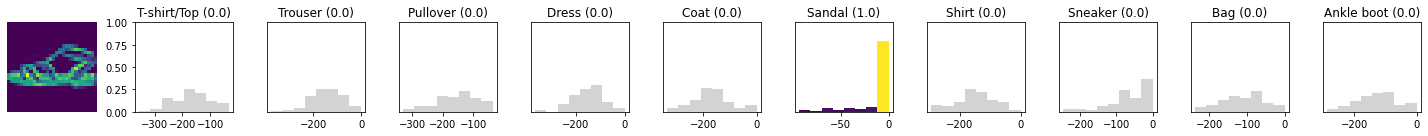

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


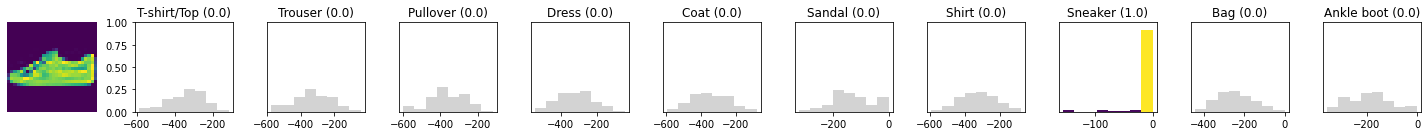

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


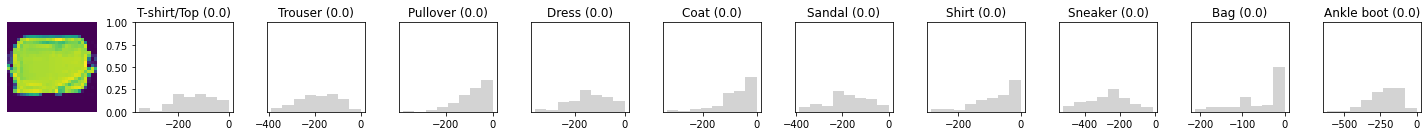

Real: Bag ===> Predicted: Undecided.
-------------------------------------------------------------


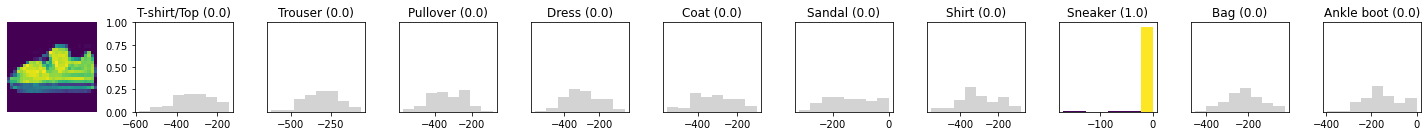

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


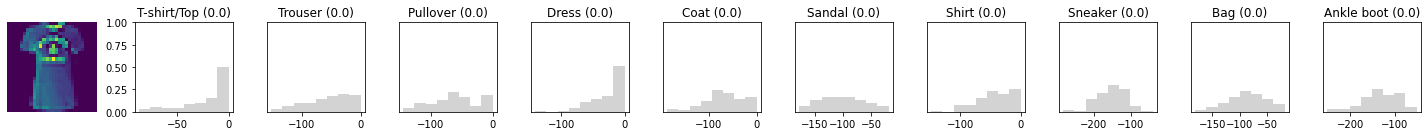

Real: T-shirt/Top ===> Predicted: Undecided.
-------------------------------------------------------------


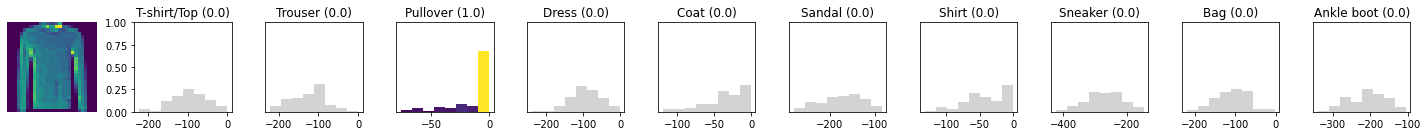

Real: Pullover ===> Predicted: Correct
-------------------------------------------------------------


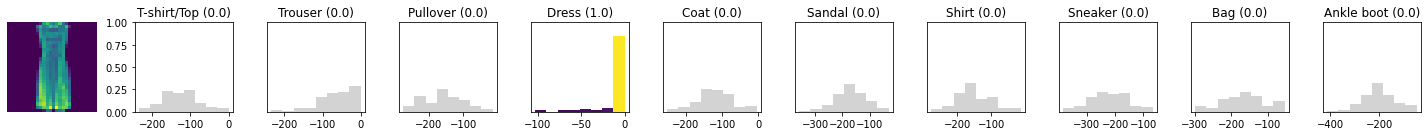

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


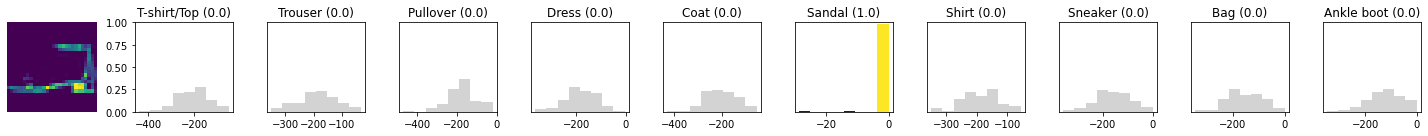

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


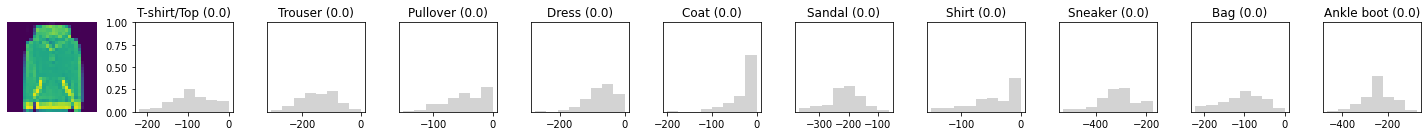

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


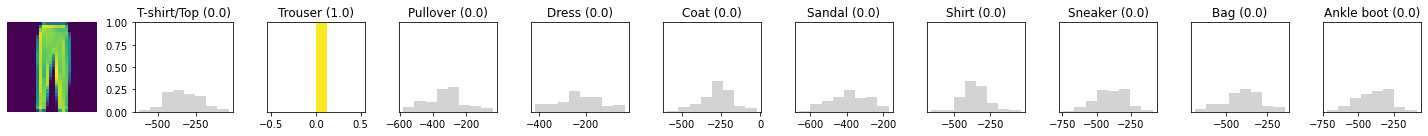

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


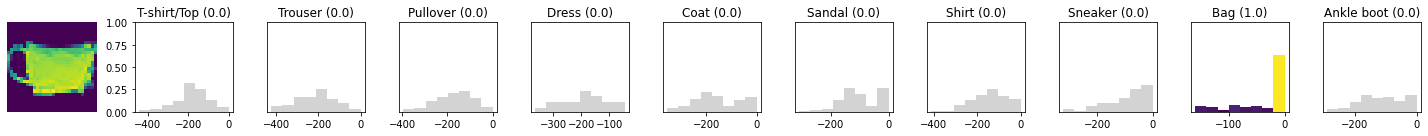

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


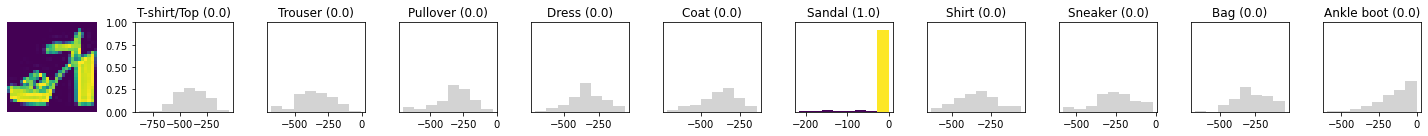

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


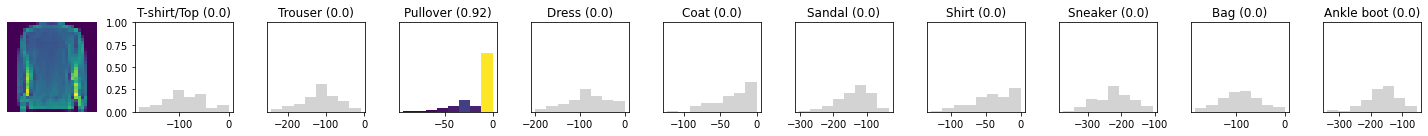

Real: Pullover ===> Predicted: Correct
-------------------------------------------------------------


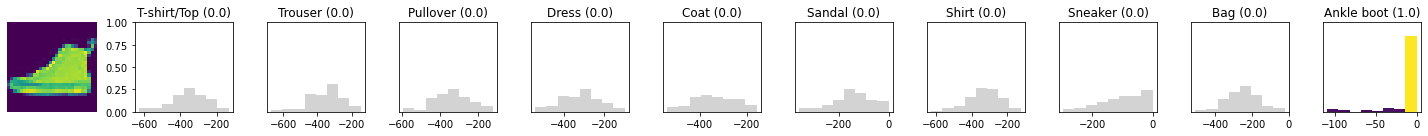

Real: Sneaker ===> Predicted: Incorrect (Ankle boot)
-------------------------------------------------------------


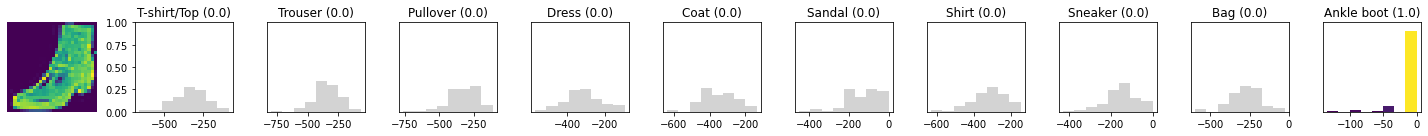

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


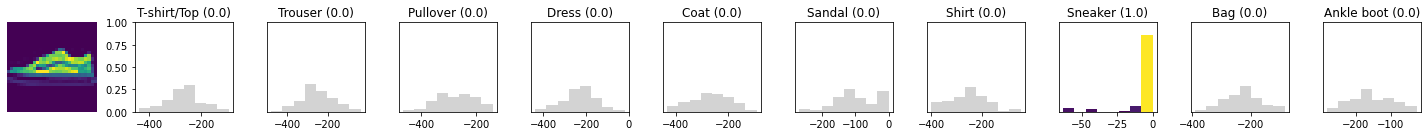

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


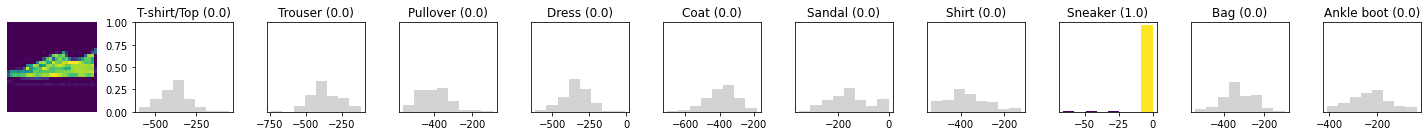

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


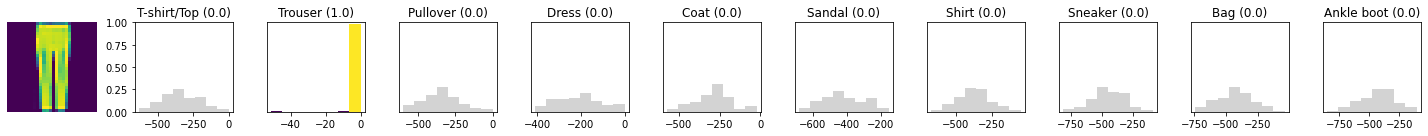

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


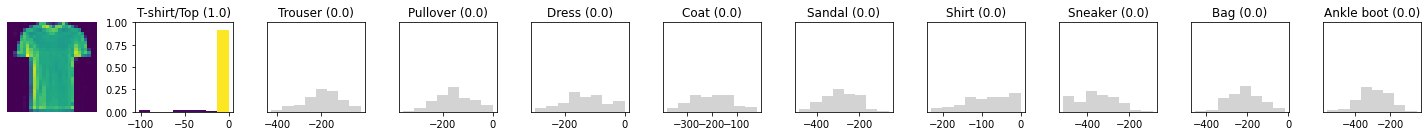

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


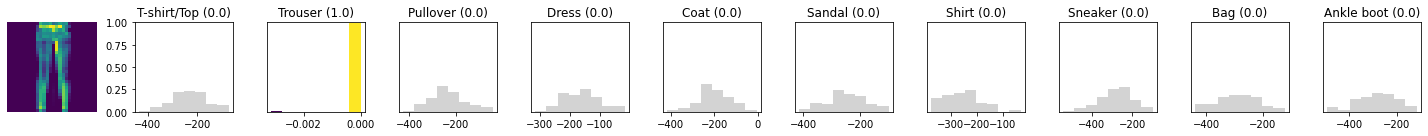

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


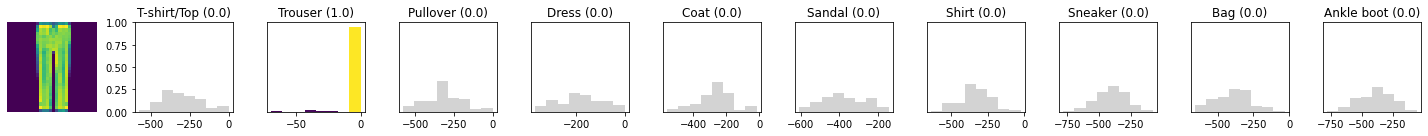

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


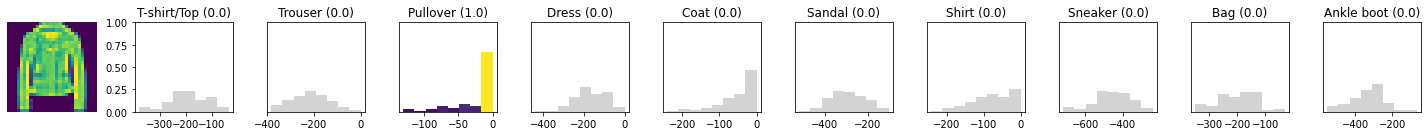

Real: Coat ===> Predicted: Incorrect (Pullover)
-------------------------------------------------------------


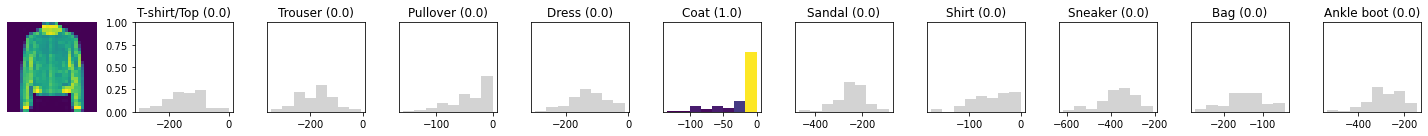

Real: Coat ===> Predicted: Correct
-------------------------------------------------------------


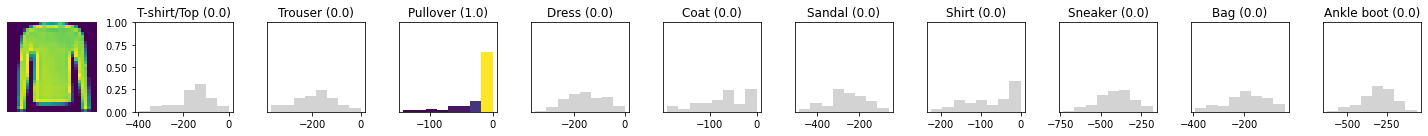

Real: Pullover ===> Predicted: Correct
-------------------------------------------------------------


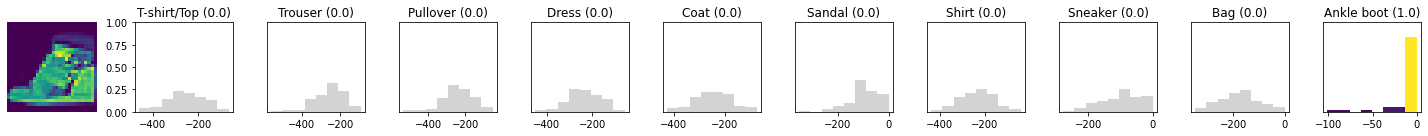

Real: Sneaker ===> Predicted: Incorrect (Ankle boot)
-------------------------------------------------------------


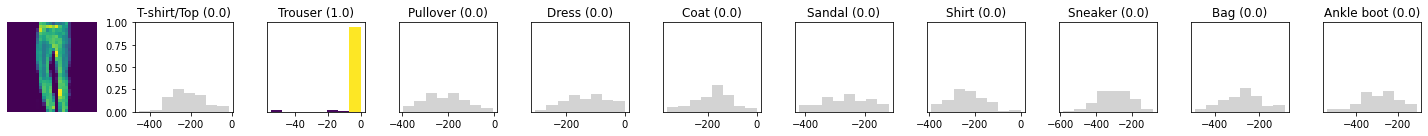

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


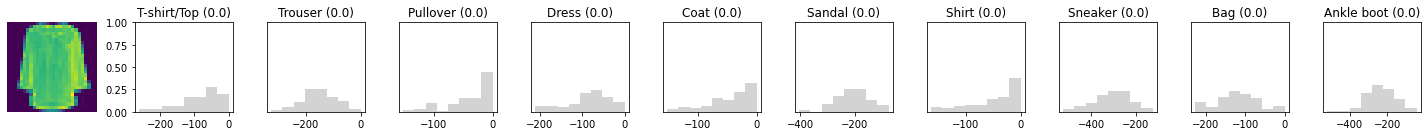

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


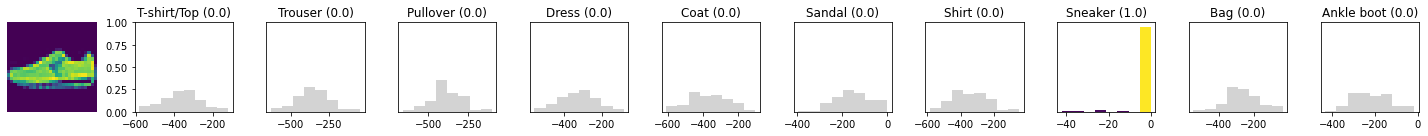

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


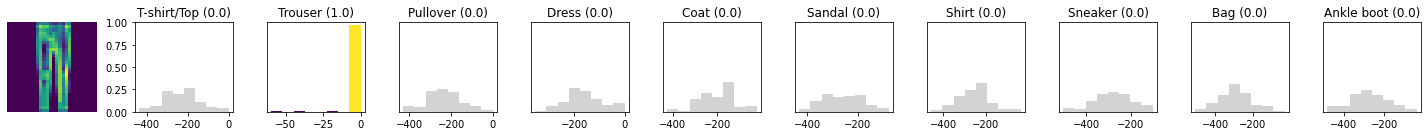

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


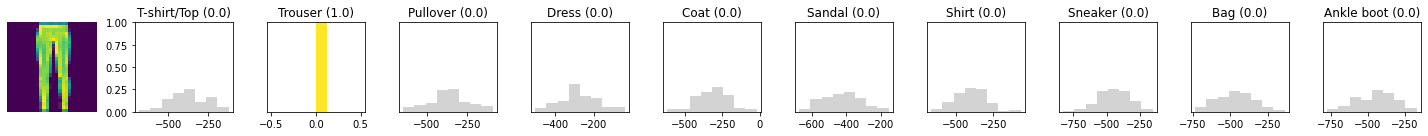

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


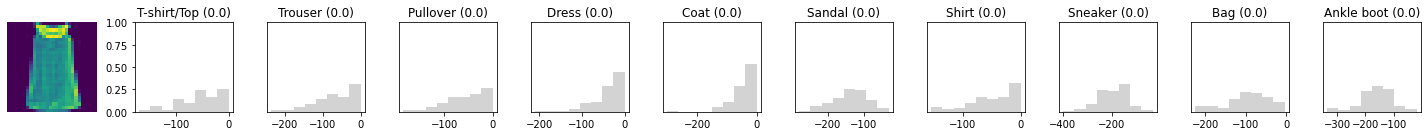

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


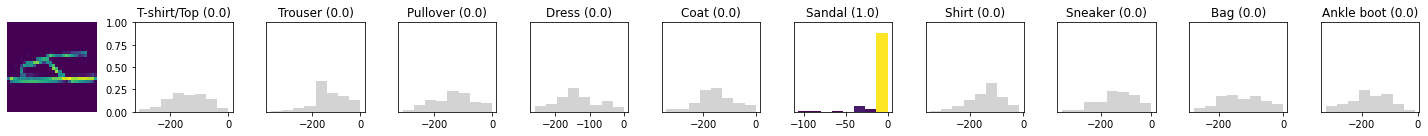

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


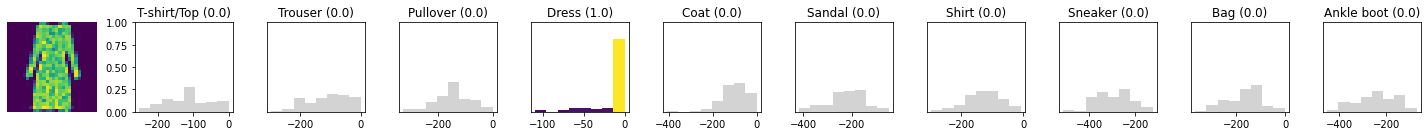

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


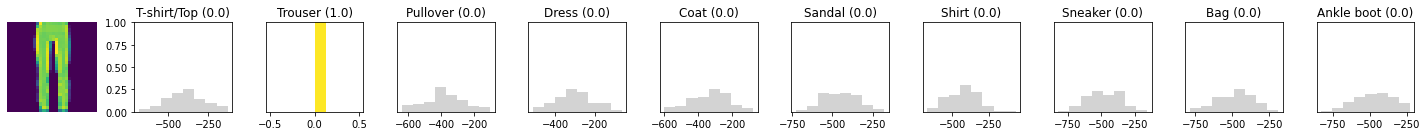

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


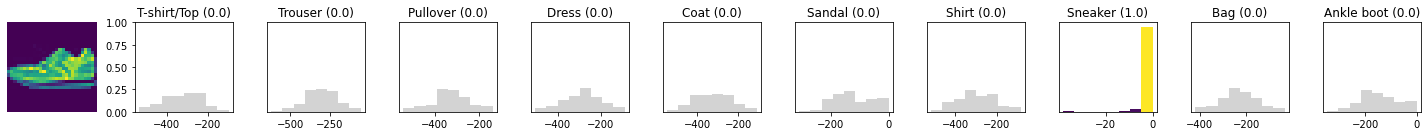

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


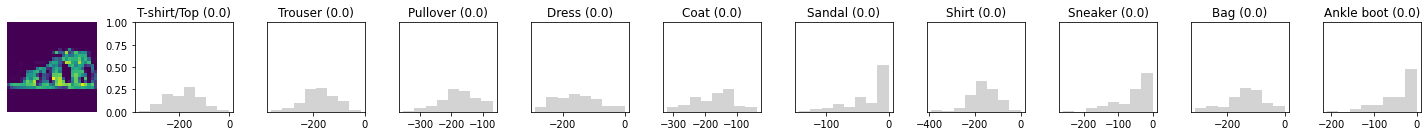

Real: Sandal ===> Predicted: Undecided.
-------------------------------------------------------------


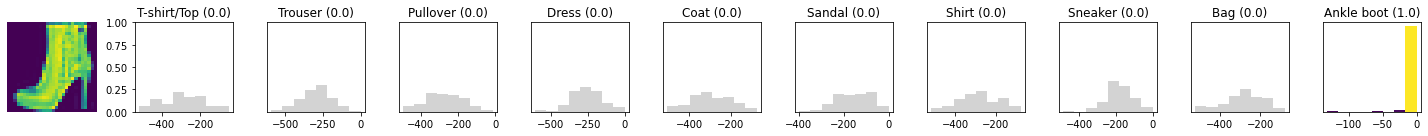

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


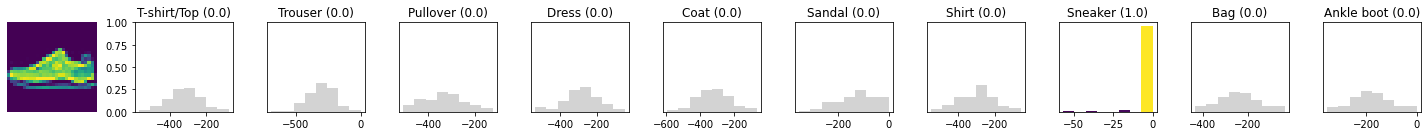

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


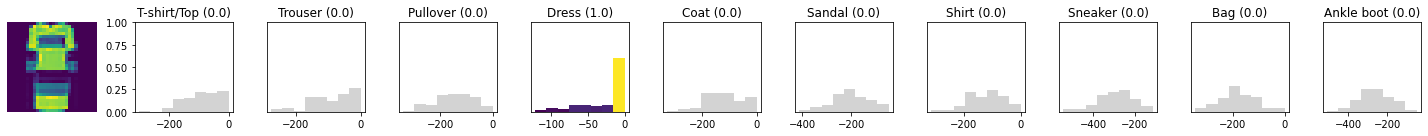

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


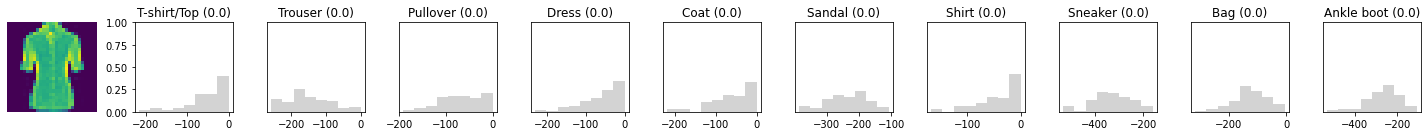

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


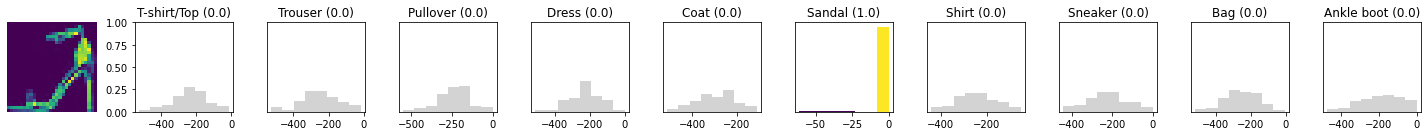

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


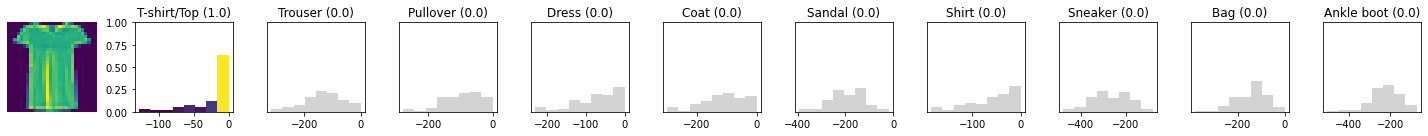

Real: Shirt ===> Predicted: Incorrect (T-shirt/Top)
-------------------------------------------------------------


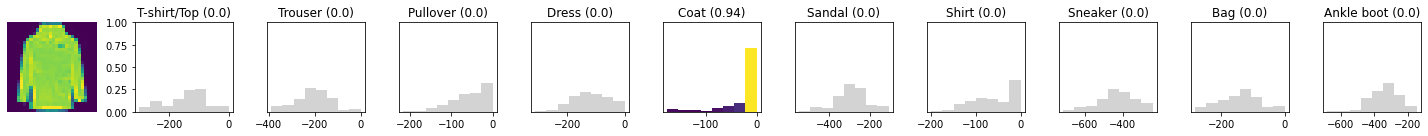

Real: Coat ===> Predicted: Correct
-------------------------------------------------------------


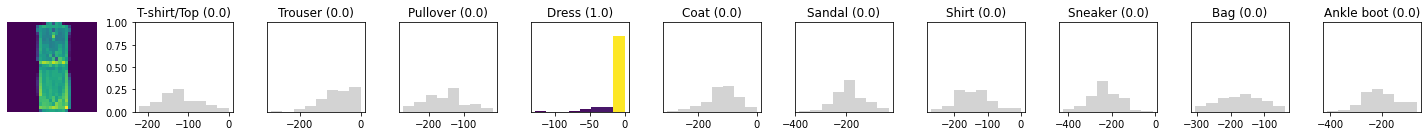

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


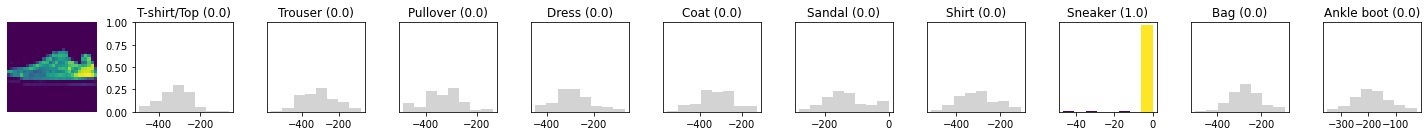

Real: Sneaker ===> Predicted: Correct
Summary
Total images:  128
Predicted for:  100
Accuracy when predicted:  0.87


(128, 87.0, 100)

In [107]:
test_batch(images[:200], labels[:200])